In [2]:
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from seaborn import set_style
set_style("whitegrid")

import seaborn as sns

from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()

# from wordcloud import WordCloud

import re
import os
from collections import Counter
import logging
import time
import pickle
import itertools


# Data Collecting 
Web-scraping reviews from Gartner

(1) Likes and dislikes

In [3]:
def get_cards(raw:str)->BeautifulSoup:
    soup = BeautifulSoup(raw)
    cards = soup.find_all("div",{"class":"review"})
    return cards

def get_tag(soup_object:BeautifulSoup)->str:
    tag = soup_object.find("h3",{"class":"likesdislikes-title"}).text
    return tag

def get_review(soup_object:BeautifulSoup) -> str:
    review_text = soup_object.find("div",{"class":"likesdislikes-text"}).text
    return review_text

def get_date(soup_object:BeautifulSoup)->str:
    date_string = soup_object.find("p",{"class":"likesdislikes-date"}).text
    return date_string

def gathering(single_review:BeautifulSoup) -> dict:
    return {
        "name":path,
        "review":get_review(single_review),
        "tag":get_tag(single_review),
        "date":get_date(single_review)               
    }

In [4]:
paths = ["icims","zoho-recruit","greenhouse","jazzHR","CEIPAL","LeverTRM","SmartRecruiters","Freshteam"]

In [5]:
results = []
err_count = 0

for path in paths:
    file = open("../data/"+path+".rtf",'r')
    raw = file.read()
    
    reviews = get_cards(raw)
    for r in reviews:
        try:
            data = gathering(r)
            results.append(data)
        except:
            err_count += 1

In [6]:
df = pd.DataFrame.from_records(results)

In [7]:
df

,name,review,tag,date
0,icims,"Ease of use, breadth of functionality and inte...",likes,"June 14, 2022"
1,icims,A few improvements in the product would be:Add...,dislikes,"May 15, 2022"
2,icims,The Textrecruit and dynamic dashboard reportin...,likes,"May 15, 2022"
3,icims,Customer ServiceNot able to reach a real techn...,dislikes,"December 1, 2022"
4,icims,Notifications EaseIntegrationEasy User Experie...,likes,"June 15, 2022"
...,...,...,...,...
232,Freshteam,1. Integrations to some of the commonly used S...,likes,"May 18, 2022"
233,Freshteam,Pricing is on a higher side for a mid-sized co...,dislikes,"November 23, 2022"
234,Freshteam,Good team management and reviewal procedure fo...,likes,"November 23, 2022"
235,Freshteam,Integration is not performed end to end ...,dislikes,"December 22, 2022"


(2) Star ratings

In [8]:
file = open("../data/ATSoverview.rtf","r")
raw = file.read()

In [9]:
soup = BeautifulSoup(raw)
cards = soup.find_all("div",{"class":"uxd-card"})

In [10]:
def get_cards(raw:str)->BeautifulSoup:
    soup = BeautifulSoup(raw)
    cards = soup.find_all("div",{"class":"uxd-card"})
    return cards

def get_star_rating(soup_object:BeautifulSoup)->str:
    star_rating = soup_object.find("div",{"class":"ratingNumber"}).text
    return float(star_rating)

def get_name(soup_object:BeautifulSoup) -> str:
    name_text = soup_object.find("a",{"class":"card-top-header"}).text
    return name_text

def get_total_ratings(soup_object:BeautifulSoup)->str:
    votes = soup_object.find("a",{"class":"rating-link"}).text
    vote_num = votes.replace(" Ratings","")
    return int(vote_num)

def gathering(single_review:BeautifulSoup) -> dict:
    return {
        "name":get_name(single_review),
        "star_rating":get_star_rating(single_review),
        "rating_votes":get_total_ratings(single_review)
    }

In [11]:
results = []
err_count = 0
    
reviews = get_cards(raw)
for r in reviews:
    try:
        data = gathering(r)
        results.append(data)
    except:
        err_count += 1

In [12]:
df_rate = pd.DataFrame.from_records(results)

In [13]:
df_rate

,name,star_rating,rating_votes
0,iCIMS Talent Cloud,4.0,66
1,Zoho Recruit,4.3,27
2,Greenhouse Recruiting,4.3,15
3,JazzHR,4.3,6
4,CEIPAL Applicant Tracking System,3.8,5
5,Lever TRM,3.5,4
6,SmartRecruiters Talent Acquisition Suite,3.6,3
7,Freshteam,4.0,2
8,Talentpool,4.0,2


In [14]:
df["name"].unique()

array(['icims', 'zoho-recruit', 'greenhouse', 'jazzHR', 'CEIPAL',
       'LeverTRM', 'SmartRecruiters', 'Freshteam'], dtype=object)

In [15]:
def name_change(company):
    company = company.replace('icims','iCIMS Talent Cloud')
    company = company.replace('zoho-recruit','Zoho Recruit')
    company = company.replace('greenhouse','Greenhouse Recruiting')
    company = company.replace('jazzHR','JazzHR')
    company = company.replace('CEIPAL','CEIPAL Applicant Tracking System')
    company = company.replace('LeverTRM','Lever TRM')
    company = company.replace('SmartRecruiters','SmartRecruiters Talent Acquisition Suite')
    return company

In [16]:
df["name"] = df["name"].apply(name_change)

## Preprocessing

In [17]:
from datetime import datetime
from dateutil import parser

In [18]:
df["date"] = df["date"].apply(parser.parse)

In [19]:
df_train = df.sample(frac = 0.8, random_state=123).copy()

In [20]:
df_test = df.drop(df_train.index).copy()

In [21]:
df_train.head()

,name,review,tag,date
108,Greenhouse Recruiting,1. Designing the Personal Welcome Experience f...,likes,2022-06-14
172,CEIPAL Applicant Tracking System,"Job board integration, Power BI that helps wit...",likes,2022-08-03
62,Zoho Recruit,"UI could be better, some buttons are misplaced...",dislikes,2021-03-11
204,SmartRecruiters Talent Acquisition Suite,standard integrations/partnerships with other ...,dislikes,2022-10-14
79,Zoho Recruit,Compact ATS which is powerful and full of grea...,likes,2022-10-28


In [22]:
df_train.tag.value_counts()

likes       95
dislikes    95
Name: tag, dtype: int64

In [23]:
df_test.tag.value_counts()

likes       25
dislikes    22
Name: tag, dtype: int64

In [24]:
from nltk.corpus import stopwords

stop = stopwords.words('english')


In [25]:
keep = ['ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 
        'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', 
        "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 
        'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 
        'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't",'but','while','against',
        'into','through','before','after','above','below','up','down','in','out','on','off',
        'over','under','again','once','few','more','most','no', 'nor', 'not', 'only','too', 
        'very','don',"don't"]

stop = [word for word in stop if word not in keep]

In [26]:
def clean_tokenizer(msg):
    return [word.lower() for word in tokenizer.tokenize(msg) if word.lower() not in stop]

In [27]:
df_train['tokens'] = df_train['review'].apply(clean_tokenizer)
df_test['tokens'] = df_test['review'].apply(clean_tokenizer)

In [28]:
#0-1 coding

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder


In [29]:
le = LabelEncoder()

In [30]:
df_train['coding'] = df_train[['tag']].apply(le.fit_transform)
df_test['coding'] = df_test[['tag']].apply(le.fit_transform)

In [31]:
# number of words

df_train['num_words'] = df_train['review'].apply(lambda x: len(str(x).split()))
df_test['num_words'] = df_test['review'].apply(lambda x: len(str(x).split()))

# Exploratory Data Analysis

- Products total reviews
- Star ratings
- dates

In [32]:
data = df.groupby('name')['tag'].value_counts().sort_values(ascending=False)

In [33]:
data

name                                      tag     
iCIMS Talent Cloud                        likes       28
                                          dislikes    27
Zoho Recruit                              dislikes    20
                                          likes       19
Greenhouse Recruiting                     dislikes    17
                                          likes       17
JazzHR                                    likes       17
Freshteam                                 likes       15
JazzHR                                    dislikes    15
Freshteam                                 dislikes    14
CEIPAL Applicant Tracking System          dislikes    10
                                          likes       10
SmartRecruiters Talent Acquisition Suite  dislikes     9
                                          likes        8
Lever TRM                                 likes        6
                                          dislikes     5
Name: tag, dtype: int64

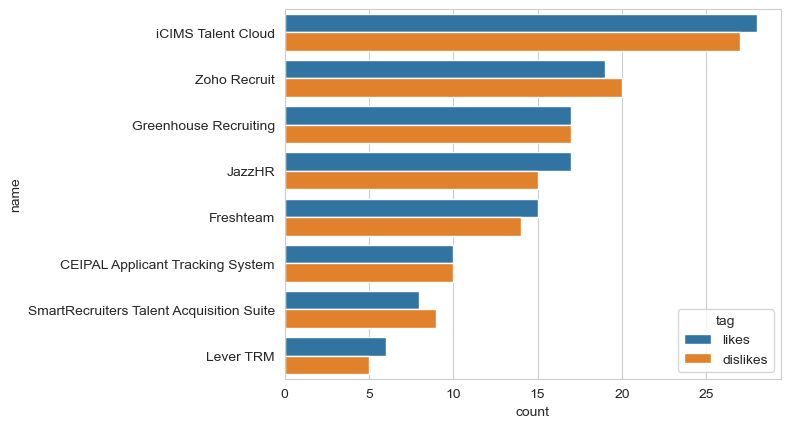

In [34]:
g = sns.countplot(data = df, y='name', hue='tag', order = df['name'].value_counts().index)


In [35]:
df_rate

,name,star_rating,rating_votes
0,iCIMS Talent Cloud,4.0,66
1,Zoho Recruit,4.3,27
2,Greenhouse Recruiting,4.3,15
3,JazzHR,4.3,6
4,CEIPAL Applicant Tracking System,3.8,5
5,Lever TRM,3.5,4
6,SmartRecruiters Talent Acquisition Suite,3.6,3
7,Freshteam,4.0,2
8,Talentpool,4.0,2


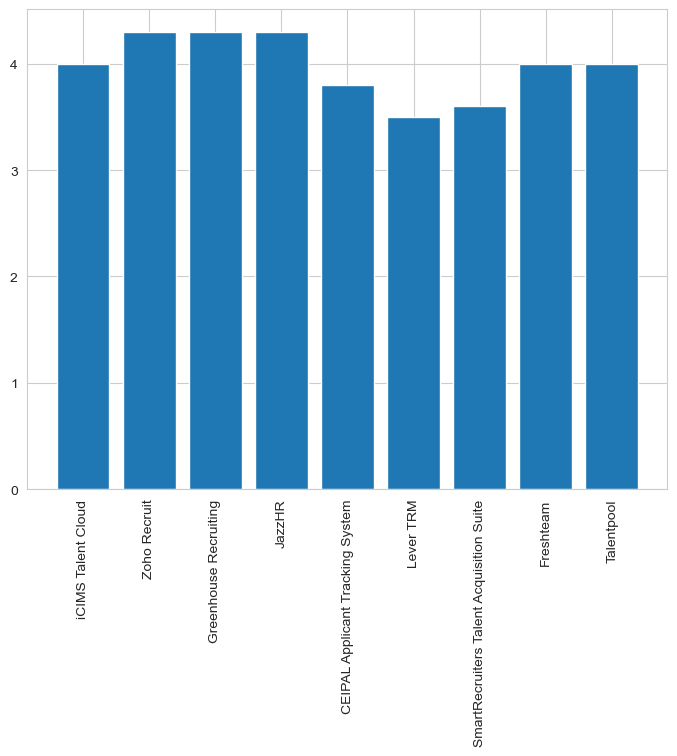

In [36]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
# ax2 = fig.add_axes([0,0,1,1])
name = df_rate['name']
star_rating = df_rate['star_rating']
rating_votes = df_rate['rating_votes']
ax.bar(name, star_rating)
# ax2.bar(name, rating_votes)
plt.xticks(rotation=90)
plt.show()

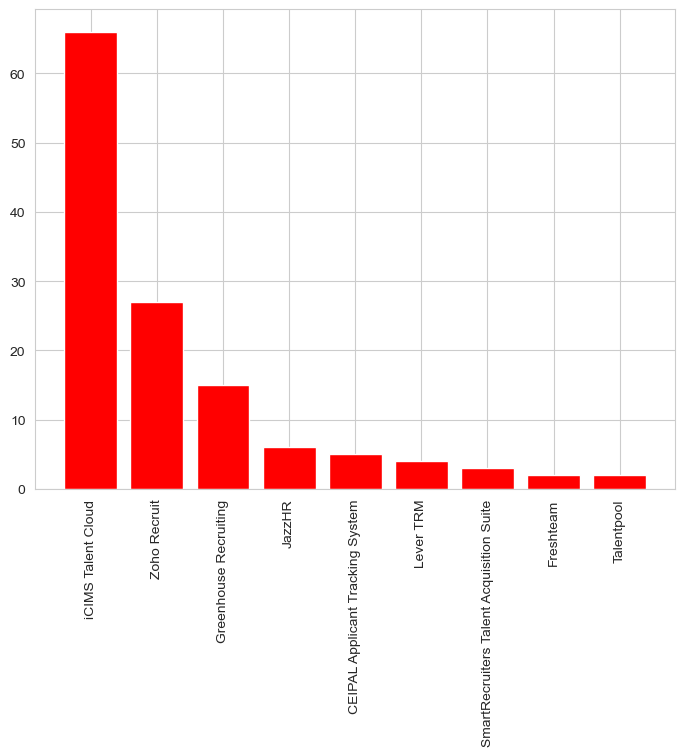

In [37]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
name = df_rate['name']
star_rating = df_rate['star_rating']
rating_votes = df_rate['rating_votes']
ax.bar(name, rating_votes, color = 'red')
plt.xticks(rotation=90)
plt.show()

In [38]:
df["date"] = df["date"].apply(lambda x:x.strftime('%Y-%m'))

In [39]:
df.date = pd.to_datetime(df.date, format = '%Y-%m')

<Axes: >

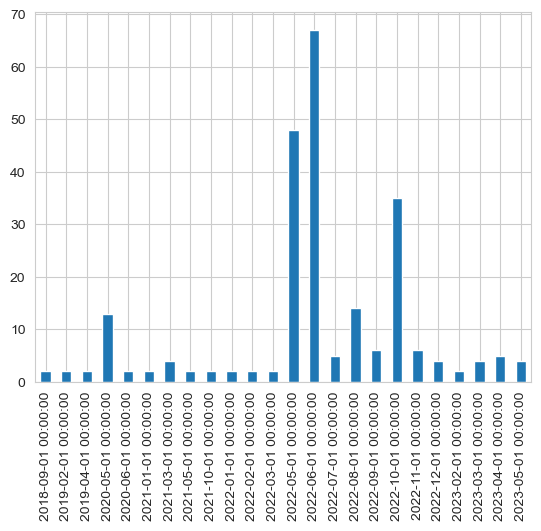

In [40]:
df["date"].value_counts().sort_index().plot(kind='bar')

Word Clouds: positive & negative

In [41]:
# Make an empty dictionary
positive_token_dict = {}

# for each positive review
for i in df_train.loc[df_train.coding==1].index:
    # extract tthe tokens
    for token in df_train.tokens[i]:
        # update the dictionary accordingly
        if token in positive_token_dict.keys():
            positive_token_dict[token] = positive_token_dict[token] + 1
        else:
            positive_token_dict[token] = 1

# store them in a dataframe for easy use
positive_token_df = pd.DataFrame({'token':positive_token_dict.keys(),
                         'times_used':positive_token_dict.values()})


In [42]:
positive_token_df.sort_values(by = 'times_used',ascending = False).head(10)

,token,times_used
1,.,95
21,...,71
25,",",62
45,easy,34
69,use,28
109,-,28
106,in,22
151,candidates,21
105,candidate,17
22,job,16


In [43]:
# Do the same thing for the negative reviews
negative_token_dict = {}

for i in df_train.loc[df_train.coding==0].index:
    for token in df_train.tokens[i]:
        if token in negative_token_dict.keys():
            negative_token_dict[token] = negative_token_dict[token] + 1
        else:
            negative_token_dict[token] = 1

negative_token_df = pd.DataFrame({'token':negative_token_dict.keys(),
                         'times_used':negative_token_dict.values()})

In [44]:
positive_top100 = set(positive_token_df.sort_values('times_used',ascending=False).head(100).token.values)
negative_top100 = set(negative_token_df.sort_values('times_used',ascending=False).head(100).token.values)

token_list = np.array(list(positive_top100.union(negative_top100)))

print(token_list)

['lot' 'on' 'most' 'still' 'free' 'seems' 'hiring' 'ease' 'onboarding'
 'no' 'customer' 'screening' 'data' 'interview' 'per' 'ability' 'process'
 'best' 'always' 'only' 'profile' 'platform' 'team' 'solution' 'service'
 '...' 'one' 'integration' 'many' 'poor' 'sometimes' 'different' 'great'
 'would' 'nothing' 'lack' 'interface' 'time' 'update' 'hr' 'functionality'
 'use' 'customizable' 'easy' 'features' 'more' 'track' '. ...' 'get' 'new'
 'dashboard' '2' 'not' 'product' 'easily' 'place' ',' 'could' 'within'
 'but' 'good' 'in' 'provides' ')' 'make' 'manage' 'able' '&' 'support'
 'vendor' 'list' 'using' 'better' 'email' 'user' 'needs' 'workflows' 'end'
 '(' 'view' 'bit' 'zoho' 'notes' 'find' 'resumes' 'ats' 'pricing' 'ai'
 'tool' 'recruiting' 'resume' '-' 'overall' '.' 'experience' 'difficult'
 'simple' 'software' 'helps' 'few' 'very' 'little' 'like' 'easier'
 'create' 'us' 'reporting' 'icims' 'recruiter' ':' 'also' 'help'
 'candidate' 'system' 'applicants' 'out' 'feature' 'too' 'need' '.

In [45]:
# data_pos = positive_top100
# wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
#               collocations=False).generate(" ".join(data_pos))
# plt.figure(figsize = (20,20))
# plt.imshow(wc)

In [46]:
# data_neg = negative_top100
# plt.figure(figsize = (20,20))
# wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
#                collocations=False).generate(" ".join(data_neg))
# plt.imshow(wc)

Distribution of number of words

In [47]:
hist_data = df_train["num_words"]

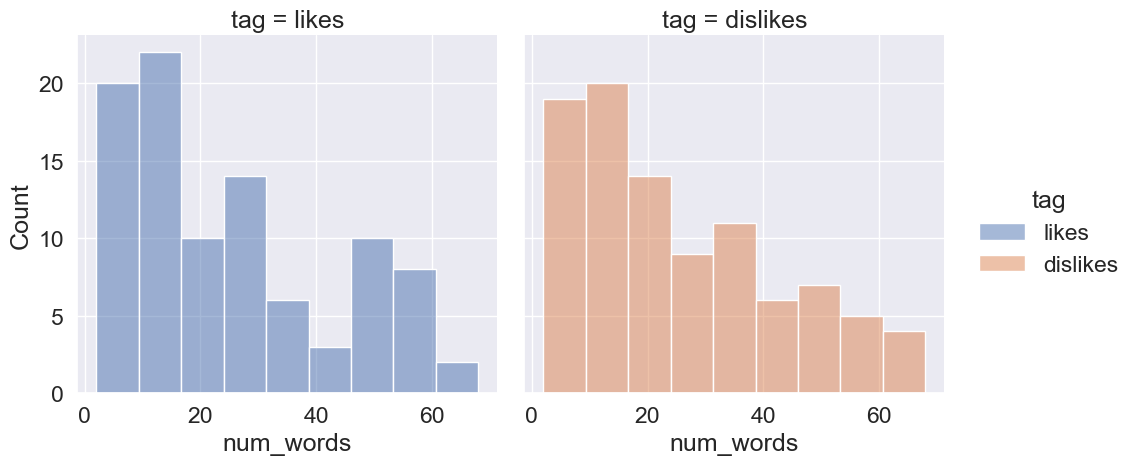

In [48]:
sns.set(font_scale=1.5)
sns.displot(df_train, x = "num_words", col="tag", hue="tag");


# Classification problem - Linear discriminant analysis, latent semenatic analysis, navie bayes, most used words, most used bigrams, SVD


(1) Navie Bayes Model

In [49]:
# Makes a zero matrix of the correct size
X_train = np.zeros((len(df_train),len(token_list)))

# for each review in the training set
for i in range(len(df_train.index)):
    # get the tokens
    for token in list(df_train.tokens)[i]:
        # if the token is in the token_list
        if token in token_list:
            # update accordingly
            X_train[i,token_list==token] = 1
            
# get the training y values
y_train = df_train.coding.values

In [50]:
# use this for your accuracy function
def acc(actual,pred):
    return np.sum(actual==pred)/len(actual)

In [51]:
from sklearn.naive_bayes import BernoulliNB

In [52]:
# Fit your model here
nb = BernoulliNB()
nb.fit(X_train,y_train)


# predict here
pred = nb.predict(X_train)

In [53]:
# Get the training accuracy here
acc(y_train,pred)

0.9263157894736842

In [54]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [55]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

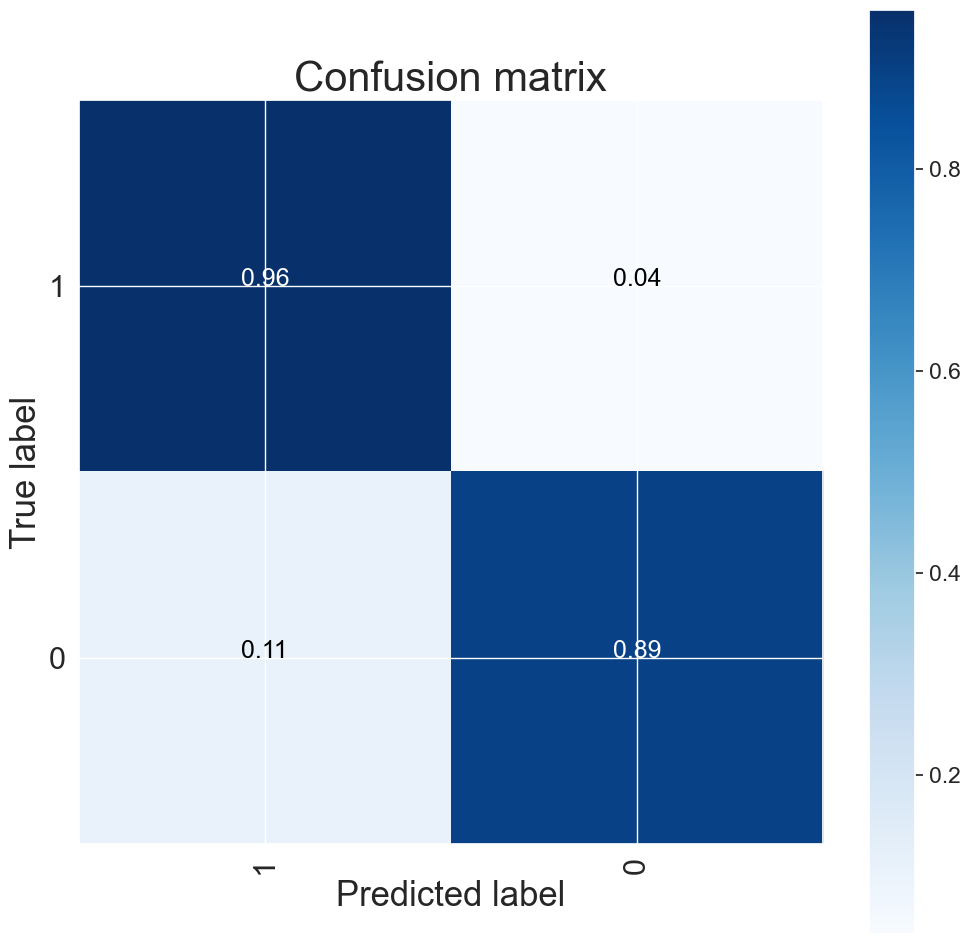

In [56]:
cnf_matrix = confusion_matrix(y_train, pred)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.coding.unique(), title="Confusion matrix")
plt.show()

(2) Linear Discriminant Analysis

In [57]:
## define functions
# This will take in a dataframe of "words" (note ngrams will work as well)
# and return a list of the unique words, which forms the basis
def get_bow_basis(df,column_name):
    basis_set = []
    
    for i in df.index:
        for word in df[column_name][i]:
            basis_set.append(word)
            
    return np.array(list(set(basis_set)))

## This will take in a basis set and a message's tokens
## and return the bow numpy array (vector)
def get_bow_vector(tokens, basis_set):
    vector = np.zeros(len(basis_set))
    
    for word in tokens:
        # Note this is here for when we look at the test set
        if word in basis_set:
            vector[basis_set == word] = vector[basis_set == word] + 1
        
    return vector

## Takes in a document term word count matrix and
## returns the idfs for the words
def get_idf(doc_term_mat):
    # how many documents are there?
    n_docs = np.shape(doc_term_mat)[0]
    
    # doc_term_mat>0 makes a boolean array of any time the array >0
    # summing along the columns gives the number of documents each term appears in
    return np.log10(n_docs/np.sum(doc_term_mat>0,axis=0))

In [58]:
basis_set = get_bow_basis(df_train,'tokens')

#### TRAINING DATA PREP ####
# this defines an array of zeros with
# number of rows equal to the number of training documents
# and number of columns equal to the number of basis_set words
doc_term_train = np.zeros((len(df_train), len(basis_set)))

# this loops through the documents in the training set
for i in range(len(df_train)):
    # each row of the array is replaced with the bag of words vector
    # for that document
    doc_term_train[i,:] = get_bow_vector(list(df_train.tokens)[i], basis_set)

    
# np.sum(array,axis=1) computes a row sum
# this will give you the word counts for your documents 
# .reshape(-1,1) turns it into a column vector
train_freq = doc_term_train/np.sum(doc_term_train,axis=1).reshape(-1,1)

train_tfidf = train_freq*get_idf(doc_term_train)

#### TEST DATA PREP ####
doc_term_test = np.zeros((len(df_test), len(basis_set)))

for i in range(len(df_test)):
    doc_term_test[i,:] = get_bow_vector(list(df_test.tokens)[i], basis_set)

# test frequency matrix
test_freq = doc_term_test

for i in range(np.shape(test_freq)[0]):
    if np.sum(test_freq[i,:]) > 0:
        test_freq[i,:] = doc_term_test[i,:]/np.sum(doc_term_test[i,:])

test_tfidf = test_freq*get_idf(doc_term_train)

In [59]:
## compute the centroids of the tfidf matrix for the reviews here
## recall that positive reviews are where df_train.coding == 1
## negative reviews are where df_train.coding == 0
positive_centroid = np.mean(train_tfidf[df_train.coding==1,:], axis=0)
negative_centroid = np.mean(train_tfidf[df_train.coding==0,:], axis=0)

In [60]:
## Now compute w by subtracting the negative centroid from the positive one
w = positive_centroid - negative_centroid

In [61]:
## This code projects the observations onto w
## we can think of this as our lda "scores"
train_lda_scores = train_tfidf.dot(w)

In [62]:
# Record the negative and positive lda scores here
negative_lda_scores = train_lda_scores[df_train.coding == 0]
positive_lda_scores = train_lda_scores[df_train.coding == 1]

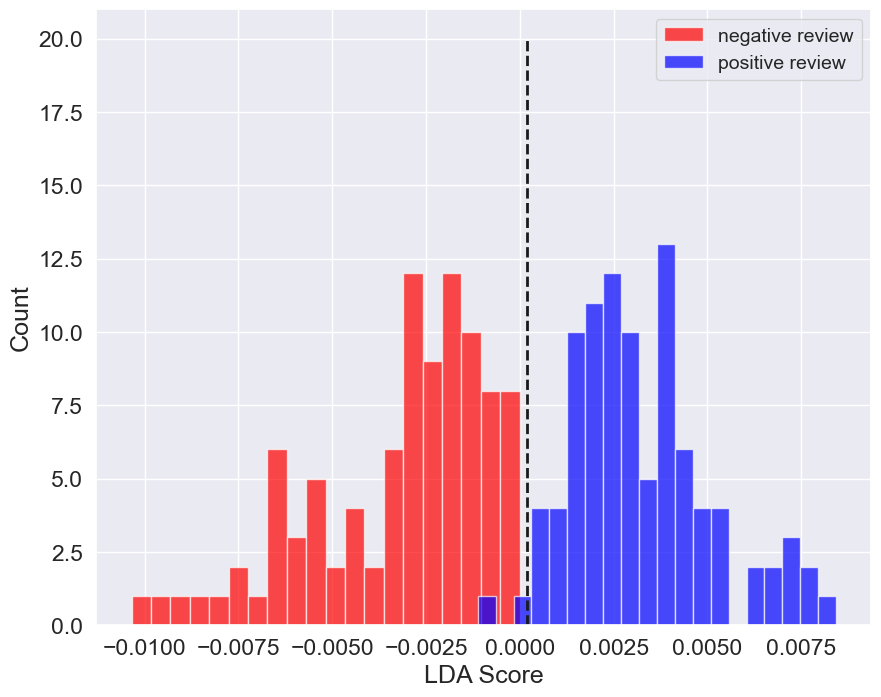

In [63]:
# Plot a histogram of the lda scores for each type of review
# make the negative bars red with alpha = .7
# make the positive bars blue with alpha = .7 as well
# use 20 bins for both
plt.figure(figsize=(10,8))

plt.hist(negative_lda_scores, color = "red", label="negative review", alpha=.7, bins=20)
plt.hist(positive_lda_scores, color = "blue", label="positive review", alpha=.7, bins=20)


plt.xlabel("LDA Score", fontsize=18)
plt.ylabel("Count", fontsize=18)

plt.plot([0.0002,0.0002],[0,20],'k--',linewidth=2)

plt.legend(fontsize=14)

plt.show()

In [64]:
# This function will predict sentiment given a threshold
def predict_sentiment(lda_scores,threshold):
    return (lda_scores >= threshold).astype(int)

In [65]:
train_pred = predict_sentiment(train_lda_scores,0.0002)

In [66]:
print("The training accuracy is",acc(df_train.coding,train_pred))

The training accuracy is 0.9947368421052631


(3) Latent Semantic Analysis using SVD and random forest

In [67]:
# get the term document matrices for each set
term_doc_train = train_tfidf.transpose()

In [68]:
# Note this may take a bit to run

# apply svd to the training set
T_train,S_train,Dt_train = np.linalg.svd(term_doc_train)

print("Done with svd decomp")

## np.linalg.matrix_rank gives the rank of the matrix
rank = len(S_train)

# We'll now replace all of our SVD output with 
# our lower rank approximation version.
T_train = T_train[:,:rank]
Dt_train = Dt_train[:rank,:]
D_train = Dt_train.transpose()
Sigma_train = np.zeros((rank,rank))

for i in range(len(S_train)):
    Sigma_train[i,i] = S_train[i]

Done with svd decomp


In [69]:
accs = []

for i in range(1,len(S_train)):
    accs.append(1-S_train[i]/np.product(np.shape(term_doc_train)))

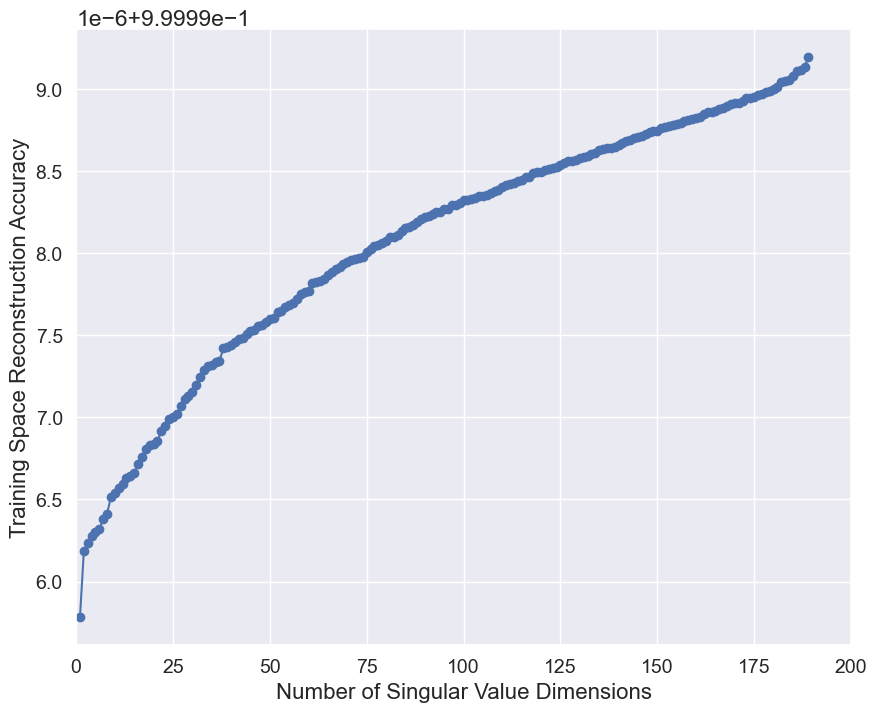

In [70]:
plt.figure(figsize=(10,8))

plt.plot(range(1,len(accs)+1),accs, '-o')

plt.xlabel("Number of Singular Value Dimensions", fontsize=16)
plt.ylabel("Training Space Reconstruction Accuracy", fontsize=16)

# plt.ylim([.999999,1])
plt.xlim([0,200])

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

In [71]:
doc_space_train = D_train.dot(Sigma_train)

In [72]:
LSA_X_train = doc_space_train[:,:100]
y_train = df_train.coding.values

In [73]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [74]:
svc = SVC()
rf = RandomForestClassifier()

In [75]:
svc.fit(LSA_X_train,y_train)
rf.fit(LSA_X_train,y_train)

RandomForestClassifier()

In [76]:
train_pred_svc = svc.predict(LSA_X_train)
train_pred_rf = rf.predict(LSA_X_train)

In [77]:
print("The training accuracy using SVC with LSA is",acc(y_train,train_pred_svc))
print("The training accuracy using RF with LSA is",acc(y_train,train_pred_rf))

The training accuracy using SVC with LSA is 0.9631578947368421
The training accuracy using RF with LSA is 1.0


### Compare The Three on the Test Set

In [78]:
# Makes a zero matrix of the correct size
X_test = np.zeros((len(df_test),len(token_list)))

# for each review in the training set
for i in range(len(df_test.index)):
    # get the tokens
    for token in list(df_test.tokens)[i]:
        # if the token is in the token_list
        if token in token_list:
            # update accordingly
            X_test[i,token_list==token] = 1
            
# get the training y values
y_test = df_test.coding.values

#### Naive Bayes

In [79]:
test_pred = nb.predict(X_test)

print("The testing accuracy of the Naive Bayes model is",acc(y_test,test_pred))

The testing accuracy of the Naive Bayes model is 0.8297872340425532


#### LDA

In [80]:
test_lda_scores = test_tfidf.dot(w)

In [81]:
test_lda_pred = predict_sentiment(test_lda_scores,0.0005)

In [82]:
print("The testing accuracy using LDA is",acc(y_test,test_lda_pred))

The testing accuracy using LDA is 0.8297872340425532


#### LSA

In [83]:
doc_space_test = test_tfidf.dot(T_train).dot(np.linalg.inv(Sigma_train))

In [84]:
LSA_X_test = doc_space_test[:,:100]
y_test = df_test.coding.values

In [85]:
test_pred_svc = svc.predict(LSA_X_test)
test_pred_rf = rf.predict(LSA_X_test)

In [86]:
print("The testing accuracy using SVC and LSA is",acc(y_test,test_pred_svc))
print("The testing accuracy using RF and LSA is",acc(y_test,test_pred_rf))

The testing accuracy using SVC and LSA is 0.723404255319149
The testing accuracy using RF and LSA is 0.7872340425531915


# Lexicon approach - VADER, Hedonometer

(1) VADER

In [87]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [88]:
analyzer = SentimentIntensityAnalyzer()

In [89]:
def get_VADER(text):
    return analyzer.polarity_scores(text)['compound']

In [90]:
df_train['VADER'] = df_train['review'].apply(get_VADER)

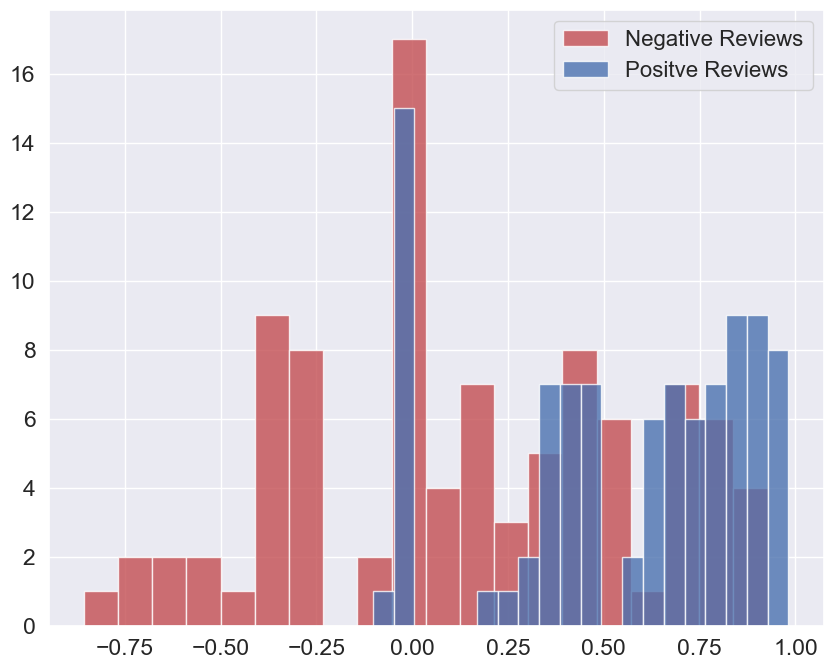

In [91]:
plt.figure(figsize=(10,8))

plt.hist(df_train.loc[df_train.coding==0].VADER.values, color='r', alpha=.8, bins=20, label = "Negative Reviews")
plt.hist(df_train.loc[df_train.coding==1].VADER.values, color='b', alpha=.8, bins=20, label = "Positve Reviews")

plt.legend(fontsize=16)

plt.show()

(2) Hedonometer

In [92]:
from nltk import RegexpTokenizer
tokenizer = RegexpTokenizer(r"\w+")

In [93]:
hedonometer = pd.read_csv("../data/Hedonometer_v1.csv")

In [94]:
hedon_dict = {}

for i in hedonometer.index:
    hedon_dict[hedonometer.word[i]] = hedonometer.happiness_score[i]

In [95]:
stop = hedonometer.loc[(hedonometer.happiness_score > 4) & 
                      (hedonometer.happiness_score < 5)].word.values

In [99]:
def get_hedonometer_words(T_words):
    return np.array([word for word in T_words if (word in hedonometer.word.values) and (word not in stop)])

# This counts the words up for us
# and stores them in a dictionary
def get_word_dict(words):
    word_dict = {}
    
    for word in words:
        if word in word_dict.keys():
            word_dict[word] = word_dict[word] + 1
        else:
            word_dict[word] = 1
                    
    return word_dict
# This will get the score for T
# return nan if T contains no words from the hedonometer
def get_hedonometer_score(T):
    # first tokenize the text
    T_words = tokenizer.tokenize(T.lower())
    
    
    # then get the hedonometer words
    T_hedonometer_words = get_hedonometer_words(T_words)
    
    # if there are no hedonometer words we can't compute a score
    if len(T_hedonometer_words) == 0:
        return np.nan
    
    # get the dictionary of counts
    T_word_dict = get_word_dict(T_hedonometer_words)
    
    # calculate the denominator of the formula
    denom = np.sum(list(T_word_dict.values()))/len(T_words)
    
    # calculate the numerator of the score
    numerator = 0
    
    for word in list(T_word_dict.keys()):
        numerator = numerator + hedon_dict[word]*T_word_dict[word]/len(T_words)
       
    # return the score
    score = numerator/denom
    
    return score

In [100]:
df_train['hedonometer'] = df_train['review'].apply(get_hedonometer_score)

In [101]:
df_train.loc[df_train.hedonometer.isna()]

,name,review,tag,date,tokens,coding,num_words,VADER,hedonometer


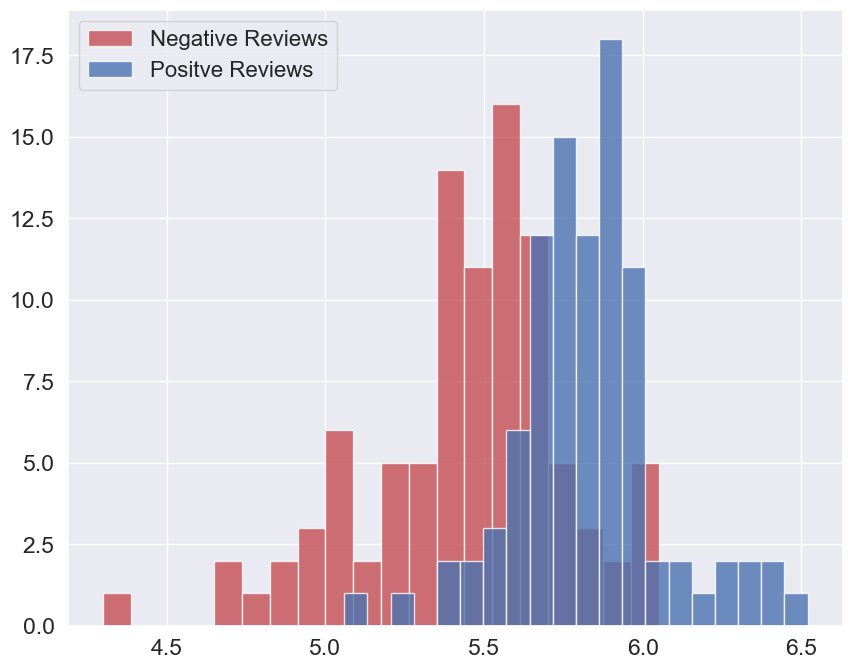

In [102]:
plt.figure(figsize=(10,8))

plt.hist(df_train.loc[df_train.coding==0].hedonometer.values, 
         color='r', alpha=.8, bins=20, label = "Negative Reviews")
plt.hist(df_train.loc[df_train.coding==1].hedonometer.values, 
         color='b', alpha=.8, bins=20, label = "Positve Reviews")
plt.legend(fontsize=16)
plt.show()

# Neural networks

In [103]:
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics

In [104]:
n = X_train.shape[1]

In [105]:
n

147

In [106]:
model = models.Sequential()

model.add(layers.Dense(16, activation='relu', input_shape=(n,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer = 'rmsprop',
                 loss = 'binary_crossentropy',
                 metrics = ['accuracy'])

In [109]:
## First make the validation set
validation_index = np.random.choice(list(range(len(X_train))),
                                    replace = False,
                                    size = 50)
partial_index = [i for i in range(len(X_train)) if i not in validation_index]


X_val_train = X_train[validation_index,:]
X_train_partial = X_train[partial_index,:]

y_val_train = y_train[validation_index]
y_train_partial = y_train[partial_index]

In [110]:
## I now fit the model, and store the training history
history = model.fit(X_train_partial,
                       y_train_partial,
                       epochs = 20,
                       batch_size = 20,
                       validation_data = (X_val_train, y_val_train))

Epoch 1/20
1/7 [===>..........................] - ETA: 0s - loss: 0.7455 - accuracy: 0.3500

2023-06-08 10:40:39.632481: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


7/7 [==============================] - 0s 12ms/step - loss: 0.7113 - accuracy: 0.4714 - val_loss: 0.6588 - val_accuracy: 0.6800
Epoch 2/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6882 - accuracy: 0.5571 - val_loss: 0.6625 - val_accuracy: 0.6200
Epoch 3/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6742 - accuracy: 0.6000 - val_loss: 0.6641 - val_accuracy: 0.6200
Epoch 4/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6625 - accuracy: 0.6643 - val_loss: 0.6647 - val_accuracy: 0.6200
Epoch 5/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6507 - accuracy: 0.7357 - val_loss: 0.6638 - val_accuracy: 0.6200
Epoch 6/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6389 - accuracy: 0.7500 - val_loss: 0.6610 - val_accuracy: 0.6400
Epoch 7/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6266 - accuracy: 0.7714 - val_loss: 0.6578 - val_accuracy: 0.6600
Epoch 8/20
7/7 [============================

In [111]:
history_dict = history.history

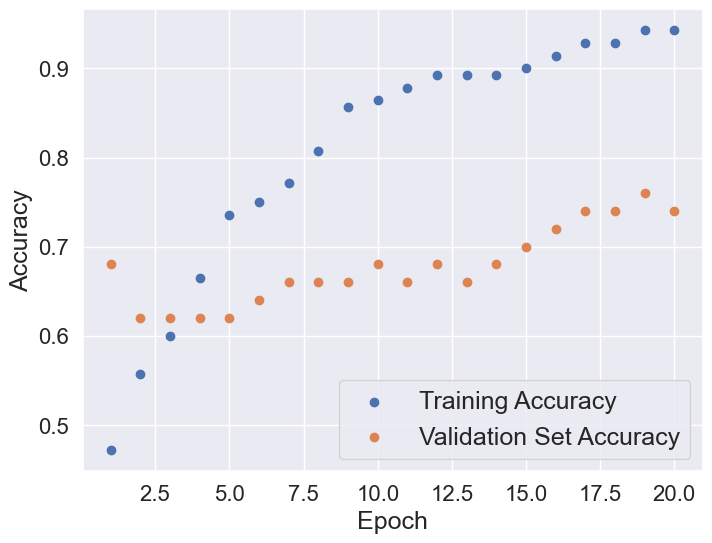

In [112]:
plt.figure(figsize = (8,6))

plt.scatter(range(1,21), history_dict['accuracy'], label = "Training Accuracy")
plt.scatter(range(1,21), history_dict['val_accuracy'], label = "Validation Set Accuracy")

plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Accuracy", fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=18)

plt.show()

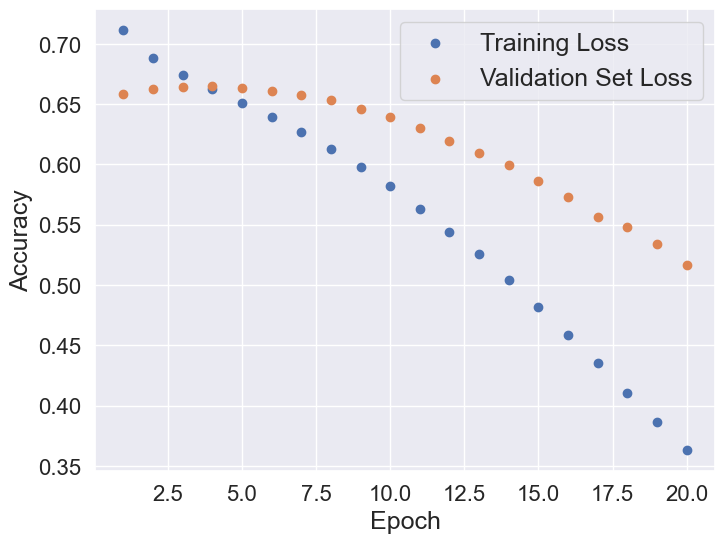

In [113]:
plt.figure(figsize = (8,6))

plt.scatter(range(1,21), history_dict['loss'], label = "Training Loss")
plt.scatter(range(1,21), history_dict['val_loss'], label = "Validation Set Loss")

plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Accuracy", fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=18)

plt.show()

In [114]:
model2 = models.Sequential()

model2.add(layers.Dense(32, activation='relu', input_shape=(n,)))
model2.add(layers.Dense(32, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.compile(optimizer = 'rmsprop',
                 loss = 'binary_crossentropy',
                 metrics = ['accuracy'])

history2 = model2.fit(X_train_partial,
                       y_train_partial,
                       epochs = 20,
                       batch_size = 32,
                       validation_data = (X_val_train, y_val_train))

history_dict2 = history2.history

Epoch 1/20
5/5 [==============================] - 0s 14ms/step - loss: 0.6952 - accuracy: 0.5214 - val_loss: 0.7032 - val_accuracy: 0.4600
Epoch 2/20
5/5 [==============================] - 0s 3ms/step - loss: 0.6561 - accuracy: 0.6357 - val_loss: 0.6980 - val_accuracy: 0.4800
Epoch 3/20
5/5 [==============================] - 0s 3ms/step - loss: 0.6323 - accuracy: 0.7286 - val_loss: 0.6916 - val_accuracy: 0.5000
Epoch 4/20
5/5 [==============================] - 0s 3ms/step - loss: 0.6084 - accuracy: 0.7571 - val_loss: 0.6872 - val_accuracy: 0.5000
Epoch 5/20
5/5 [==============================] - 0s 3ms/step - loss: 0.5873 - accuracy: 0.7643 - val_loss: 0.6853 - val_accuracy: 0.5000
Epoch 6/20
5/5 [==============================] - 0s 3ms/step - loss: 0.5653 - accuracy: 0.7786 - val_loss: 0.6767 - val_accuracy: 0.5200
Epoch 7/20
5/5 [==============================] - 0s 3ms/step - loss: 0.5429 - accuracy: 0.8071 - val_loss: 0.6656 - val_accuracy: 0.5600
Epoch 8/20
5/5 [=================

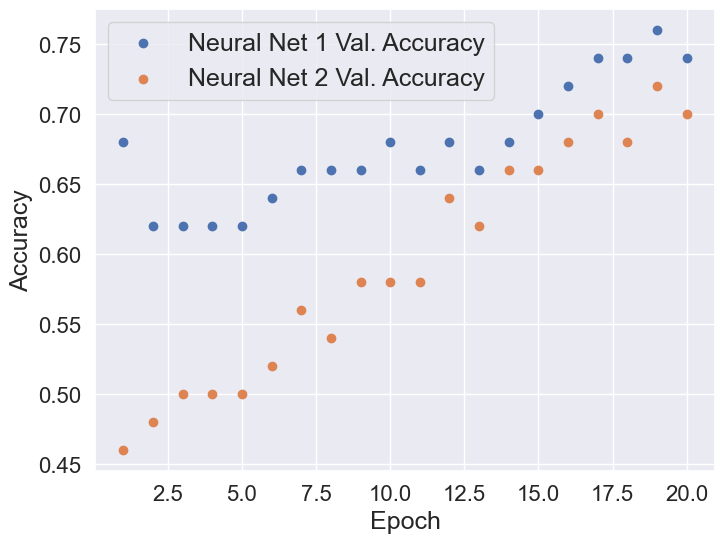

In [115]:
plt.figure(figsize = (8,6))

plt.scatter(range(1,21), history_dict['val_accuracy'], label = "Neural Net 1 Val. Accuracy")
plt.scatter(range(1,21), history_dict2['val_accuracy'], label = "Neural Net 2 Val. Accuracy")

plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Accuracy", fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=18)

plt.show()

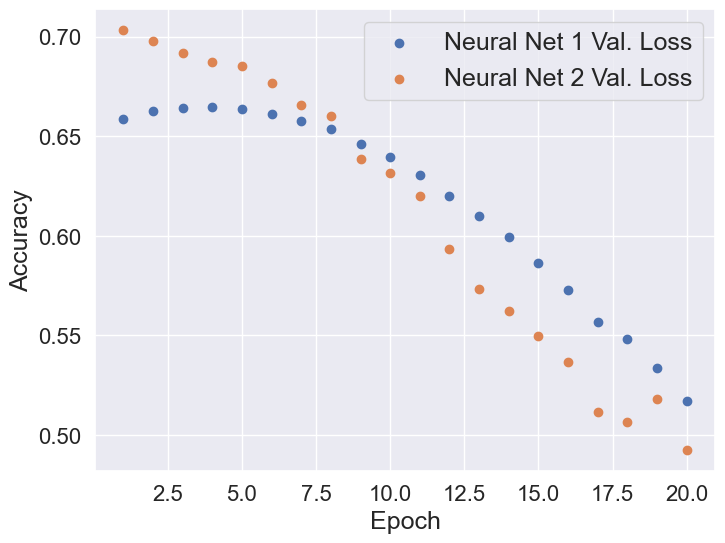

In [116]:
plt.figure(figsize = (8,6))

plt.scatter(range(1,21), history_dict['val_loss'], label = "Neural Net 1 Val. Loss")
plt.scatter(range(1,21), history_dict2['val_loss'], label = "Neural Net 2 Val. Loss")

plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Accuracy", fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=18)

plt.show()

In [117]:
from sklearn.decomposition import PCA

In [118]:
# This is done just to improve the speed of fitting the network
# This has nothing to do with making a better model
pca = PCA(n_components = 100)

pca.fit(train_tfidf)

X_train = pca.transform(train_tfidf)
X_test = pca.transform(test_tfidf)

In [119]:
validation_index = np.random.choice(list(range(np.shape(X_train)[0])),
                                    replace = False,
                                    size = 50)
partial_index = [i for i in range(np.shape(X_train)[0]) if i not in validation_index]


X_partial_train = X_train[partial_index,:]
X_val = X_train[validation_index]

y_partial_train = y_train[partial_index]
y_val = y_train[validation_index]

In [120]:
### Our OG set up from above
model1 = models.Sequential()

model1.add(layers.Dense(16, activation='relu', input_shape=(100,)))
model1.add(layers.Dense(16, activation='relu'))
model1.add(layers.Dense(1, activation='sigmoid'))

model1.compile(optimizer = 'rmsprop',
                 loss = 'binary_crossentropy',
                 metrics = ['accuracy'])

history1 = model1.fit(X_partial_train,
                       y_partial_train,
                       epochs = 50,
                       batch_size = 10,
                       validation_data = (X_val, y_val))

history_dict1 = history1.history

Epoch 1/50
14/14 [==============================] - 0s 4ms/step - loss: 0.6930 - accuracy: 0.5071 - val_loss: 0.6932 - val_accuracy: 0.5200
Epoch 2/50
14/14 [==============================] - 0s 1ms/step - loss: 0.6904 - accuracy: 0.6071 - val_loss: 0.6932 - val_accuracy: 0.5600
Epoch 3/50
14/14 [==============================] - 0s 1ms/step - loss: 0.6887 - accuracy: 0.5857 - val_loss: 0.6930 - val_accuracy: 0.5200
Epoch 4/50
14/14 [==============================] - 0s 1ms/step - loss: 0.6868 - accuracy: 0.6714 - val_loss: 0.6926 - val_accuracy: 0.5200
Epoch 5/50
14/14 [==============================] - 0s 1ms/step - loss: 0.6846 - accuracy: 0.6786 - val_loss: 0.6921 - val_accuracy: 0.4800
Epoch 6/50
14/14 [==============================] - 0s 1ms/step - loss: 0.6824 - accuracy: 0.6857 - val_loss: 0.6917 - val_accuracy: 0.5000
Epoch 7/50
14/14 [==============================] - 0s 1ms/step - loss: 0.6795 - accuracy: 0.7214 - val_loss: 0.6910 - val_accuracy: 0.5000
Epoch 8/50
14/14 [==

In [121]:
### A smaller network
model2 = models.Sequential()

model2.add(layers.Dense(4, activation='relu', input_shape=(100,)))
model2.add(layers.Dense(4, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.compile(optimizer = 'rmsprop',
                 loss = 'binary_crossentropy',
                 metrics = ['accuracy'])

history2 = model2.fit(X_partial_train,
                       y_partial_train,
                       epochs = 50,
                       batch_size = 10,
                       validation_data = (X_val, y_val))

history_dict2 = history2.history

Epoch 1/50
14/14 [==============================] - 0s 4ms/step - loss: 0.6934 - accuracy: 0.4643 - val_loss: 0.6923 - val_accuracy: 0.5800
Epoch 2/50
14/14 [==============================] - 0s 1ms/step - loss: 0.6919 - accuracy: 0.5143 - val_loss: 0.6921 - val_accuracy: 0.5800
Epoch 3/50
14/14 [==============================] - 0s 1ms/step - loss: 0.6910 - accuracy: 0.5571 - val_loss: 0.6918 - val_accuracy: 0.5200
Epoch 4/50
14/14 [==============================] - 0s 1ms/step - loss: 0.6899 - accuracy: 0.5786 - val_loss: 0.6916 - val_accuracy: 0.5800
Epoch 5/50
14/14 [==============================] - 0s 1ms/step - loss: 0.6888 - accuracy: 0.5786 - val_loss: 0.6914 - val_accuracy: 0.5400
Epoch 6/50
14/14 [==============================] - 0s 1ms/step - loss: 0.6878 - accuracy: 0.5857 - val_loss: 0.6912 - val_accuracy: 0.5000
Epoch 7/50
14/14 [==============================] - 0s 1ms/step - loss: 0.6864 - accuracy: 0.5929 - val_loss: 0.6910 - val_accuracy: 0.4800
Epoch 8/50
14/14 [==

In [122]:
### A Larger network
model3 = models.Sequential()

model3.add(layers.Dense(256, activation='relu', input_shape=(100,)))
model3.add(layers.Dense(256, activation='relu'))
model3.add(layers.Dense(1, activation='sigmoid'))

model3.compile(optimizer = 'rmsprop',
                 loss = 'binary_crossentropy',
                 metrics = ['accuracy'])

history3 = model3.fit(X_partial_train,
                       y_partial_train,
                       epochs = 50,
                       batch_size = 10,
                       validation_data = (X_val, y_val))

history_dict3 = history3.history

Epoch 1/50
14/14 [==============================] - 0s 5ms/step - loss: 0.6937 - accuracy: 0.5214 - val_loss: 0.6887 - val_accuracy: 0.6200
Epoch 2/50
14/14 [==============================] - 0s 1ms/step - loss: 0.6761 - accuracy: 0.7786 - val_loss: 0.6836 - val_accuracy: 0.5400
Epoch 3/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6513 - accuracy: 0.8143 - val_loss: 0.6703 - val_accuracy: 0.6600
Epoch 4/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6034 - accuracy: 0.8429 - val_loss: 0.6471 - val_accuracy: 0.6600
Epoch 5/50
14/14 [==============================] - 0s 2ms/step - loss: 0.5370 - accuracy: 0.9143 - val_loss: 0.6193 - val_accuracy: 0.7400
Epoch 6/50
14/14 [==============================] - 0s 2ms/step - loss: 0.4427 - accuracy: 0.9071 - val_loss: 0.5915 - val_accuracy: 0.7400
Epoch 7/50
14/14 [==============================] - 0s 2ms/step - loss: 0.3566 - accuracy: 0.9214 - val_loss: 0.5612 - val_accuracy: 0.7200
Epoch 8/50
14/14 [==

In [123]:
### A deep network
model4 = models.Sequential()

model4.add(layers.Dense(16, activation='relu', input_shape=(100,)))
model4.add(layers.Dense(16, activation='relu'))
model4.add(layers.Dense(16, activation='relu'))
model4.add(layers.Dense(1, activation='sigmoid'))

model4.compile(optimizer = 'rmsprop',
                 loss = 'binary_crossentropy',
                 metrics = ['accuracy'])

history4 = model4.fit(X_partial_train,
                       y_partial_train,
                       epochs = 50,
                       batch_size = 10,
                       validation_data = (X_val, y_val))

history_dict4 = history4.history

Epoch 1/50
14/14 [==============================] - 0s 5ms/step - loss: 0.6933 - accuracy: 0.4857 - val_loss: 0.6941 - val_accuracy: 0.4800
Epoch 2/50
14/14 [==============================] - 0s 1ms/step - loss: 0.6918 - accuracy: 0.5500 - val_loss: 0.6939 - val_accuracy: 0.4800
Epoch 3/50
14/14 [==============================] - 0s 1ms/step - loss: 0.6904 - accuracy: 0.6000 - val_loss: 0.6937 - val_accuracy: 0.4600
Epoch 4/50
14/14 [==============================] - 0s 1ms/step - loss: 0.6889 - accuracy: 0.6571 - val_loss: 0.6933 - val_accuracy: 0.4800
Epoch 5/50
14/14 [==============================] - 0s 1ms/step - loss: 0.6870 - accuracy: 0.6929 - val_loss: 0.6928 - val_accuracy: 0.5400
Epoch 6/50
14/14 [==============================] - 0s 1ms/step - loss: 0.6850 - accuracy: 0.7214 - val_loss: 0.6924 - val_accuracy: 0.5200
Epoch 7/50
14/14 [==============================] - 0s 1ms/step - loss: 0.6821 - accuracy: 0.7357 - val_loss: 0.6921 - val_accuracy: 0.5800
Epoch 8/50
14/14 [==

In [125]:
history_dict1['val_accuracy']

[0.5199999809265137,
 0.5600000023841858,
 0.5199999809265137,
 0.5199999809265137,
 0.47999998927116394,
 0.5,
 0.5,
 0.5400000214576721,
 0.5600000023841858,
 0.5600000023841858,
 0.5600000023841858,
 0.5600000023841858,
 0.5400000214576721,
 0.5400000214576721,
 0.5400000214576721,
 0.5600000023841858,
 0.5600000023841858,
 0.5799999833106995,
 0.5799999833106995,
 0.6000000238418579,
 0.5799999833106995,
 0.6200000047683716,
 0.6000000238418579,
 0.5799999833106995,
 0.5799999833106995,
 0.6399999856948853,
 0.6200000047683716,
 0.6399999856948853,
 0.6399999856948853,
 0.6399999856948853,
 0.6600000262260437,
 0.6600000262260437,
 0.6800000071525574,
 0.6800000071525574,
 0.6800000071525574,
 0.699999988079071,
 0.6600000262260437,
 0.6800000071525574,
 0.6800000071525574,
 0.6800000071525574,
 0.6600000262260437,
 0.6800000071525574,
 0.6800000071525574,
 0.6800000071525574,
 0.6800000071525574,
 0.6800000071525574,
 0.6600000262260437,
 0.6600000262260437,
 0.6399999856948853,
 

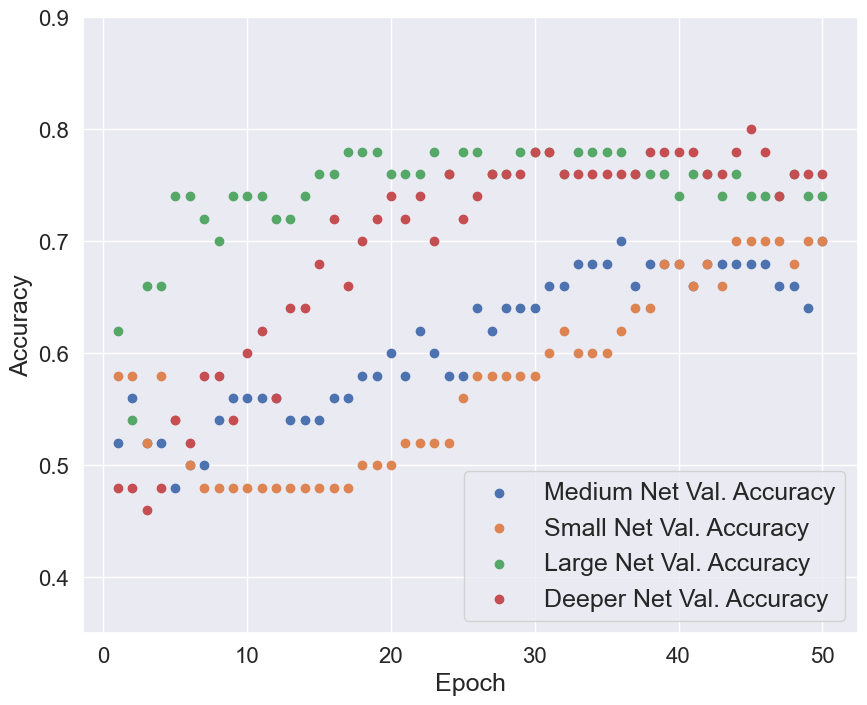

In [129]:
plt.figure(figsize = (10,8))

plt.scatter(range(1,51), history_dict1['val_accuracy'], label = "Medium Net Val. Accuracy")
plt.scatter(range(1,51), history_dict2['val_accuracy'], label = "Small Net Val. Accuracy")
plt.scatter(range(1,51), history_dict3['val_accuracy'], label = "Large Net Val. Accuracy")
plt.scatter(range(1,51), history_dict4['val_accuracy'], label = "Deeper Net Val. Accuracy")

plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Accuracy", fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=18,loc=4)

plt.ylim(.35,0.90)

plt.show()

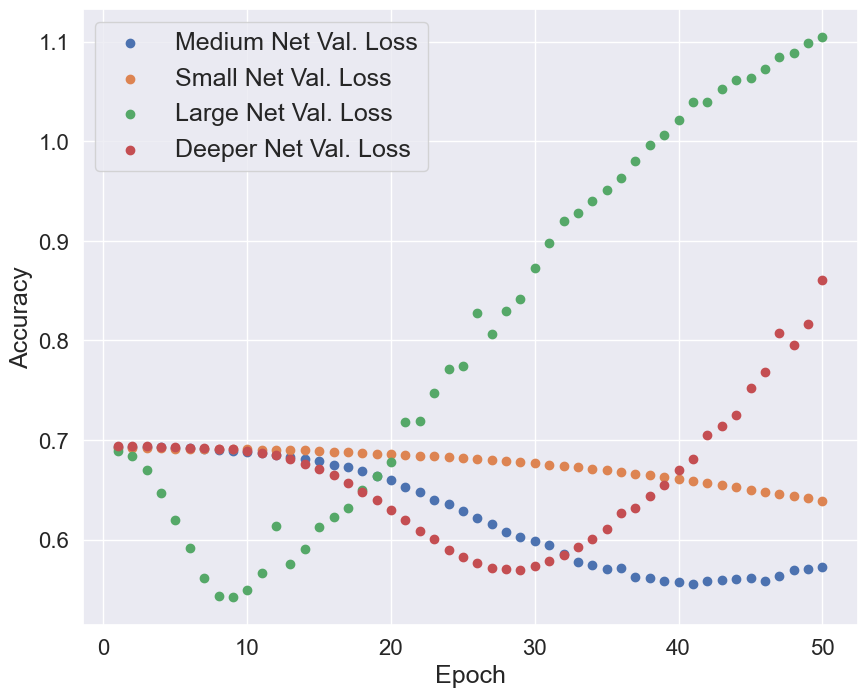

In [130]:
plt.figure(figsize = (10,8))

plt.scatter(range(1,51), history_dict1['val_loss'], label = "Medium Net Val. Loss")
plt.scatter(range(1,51), history_dict2['val_loss'], label = "Small Net Val. Loss")
plt.scatter(range(1,51), history_dict3['val_loss'], label = "Large Net Val. Loss")
plt.scatter(range(1,51), history_dict4['val_loss'], label = "Deeper Net Val. Loss")


plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Accuracy", fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=18)

plt.show()

# Word2Vec

In [133]:
import gensim.downloader as api

In [131]:
from gensim.models import Word2Vec

In [134]:
wv = api.load('word2vec-google-news-300')

In [135]:
# You'll need these
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics

In [136]:
# You train a Word2Vec model in gensim with
# Word2Vec
from gensim.models import Word2Vec

In [150]:
from itertools import chain

In [143]:
from nltk.tokenize import sent_tokenize
from nltk import word_tokenize

In [154]:
df_train['sentences'] = df_train['review'].apply(lambda x: [word_tokenize(sent) for sent in sent_tokenize(x.lower())])

In [157]:
sents = list(chain.from_iterable(df_train['sentences']))

In [159]:
# This line makes a model
# You first put in your sentences
# then you can OPTIONALLY specify a number of parameters
# vector_size is the size of the hidden layer
# window is the size of the skip-gram window
# min_count sets a minimum number of times that a word has to appear
model = Word2Vec(sentences = sents,
#                      size=10,  
                     window=1, 
                     min_count=1)

In [161]:
model.wv['easy']

array([-1.82473182e-03,  5.92430914e-03,  2.82732118e-03,  1.04133887e-02,
        1.00954995e-03, -9.06657614e-03,  3.00571526e-04,  6.64366595e-03,
       -4.76922607e-03, -9.44272708e-03, -5.91448089e-03, -9.92784463e-03,
        6.11766241e-03,  5.60074020e-03,  8.96327384e-03,  5.51324803e-03,
       -5.76493610e-03,  9.43342748e-04,  7.63594266e-03, -2.80260434e-03,
        5.16485423e-03,  6.77056843e-03, -7.14083342e-03,  7.90356752e-03,
        5.75499004e-03,  8.58901720e-03, -9.94307455e-03,  4.58425190e-03,
        4.49514994e-03, -1.42078416e-03, -3.99643742e-03,  5.33235818e-03,
       -5.84941078e-03, -7.02541834e-03,  2.50088121e-03,  1.16387326e-02,
        9.16488841e-03, -6.09632861e-03, -1.01498235e-02,  6.04465371e-03,
        7.29259942e-03, -6.14217296e-03, -9.56063904e-03, -5.11779776e-03,
       -2.16548447e-03, -3.29993502e-03, -9.22222098e-04, -5.80540218e-04,
       -6.58042554e-04, -5.17670391e-03,  1.03008412e-02, -6.77807955e-03,
       -7.25134229e-03,  

In [162]:
model.wv.most_similar(['easy'])

[('to', 0.33997341990470886),
 ('with', 0.3238525986671448),
 ('loading', 0.31049844622612),
 ('open', 0.3083786964416504),
 ('place', 0.3073061406612396),
 ('period', 0.29916709661483765),
 ('accomplish', 0.28701743483543396),
 ('specifically', 0.2795567512512207),
 ('streamline', 0.27616047859191895),
 ('ats', 0.27263978123664856)]

In [164]:
model.save("ATSreview.model")

In [166]:
# how to train a classifier or a neural network using this Word2Vec model?

# BERT

# Review generator - markovify

In [169]:
import markovify

In [178]:
joined_review = ' '.join(df['review'].str.lower())

In [179]:
joined_review

'ease of use, breadth of functionality and integration capabilities make it a great solution....  a few improvements in the product would be:addition of ai: an addition of ai can understand the needs of the dynamic job market, and thus provide customized solution for the requirements as per the market scenariothe company may work on the design and make it a bit intutive because the design ... ...  the textrecruit and dynamic dashboard reporting for a user are two really helpful feature. ...  customer servicenot able to reach a real techniciancustomer service...  notifications easeintegrationeasy user experience...  the reporting is not efficient....  - pricing- functionality (top in this area)- ease of use- users can easily manage their workload...  not advanced for the needs of the current changing job market.struggle with reporting & analytics.the use of ai in the tool would help recruitment a great deal....  talent assessments, very simple , large data handling and  interface . ... 

In [180]:
review_model = markovify.Text(joined_review)

In [181]:
for i in range(5):
    print(review_model.make_sentence())
    print()

1. one stop solution for all hr workflow procedures - right from candidate sourcing to onboardin2. building experience for new joinees2. automation of all the job description was nice too....

also, the people at icims are very few weaknesses to this software. it has been difficult for a streamline process when hiring new employees. it can be top in class when most of the pool of candidates. the forms are not as efficient as i interview and track where applicants are in the different groups of two thousands peoples again and again....

easy to use & understand.good help guide /knowledge base available to understand that you have the ability to generate links for referrals. also, i love the fact that freshteam does not integrate with other vendors where we need data from...

poor customer handlings and also manage all employee information and share it with the dashboard feature quite a useful tool.- maintaining the records and resumes is very easy....

- it is extremely easy to use and 

In [182]:
a = "it is extremely easy to use and get used to evaluate the candidate"